## Introduction

This notebook aims to continue the analysis of running biomechanics provided in a dataset made publicly available by Fukuchi et al. (2017) in a paper exploring the effect of velocity on running biomechanics.

__Source__<br>
The research paper is available [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5426356/).<br>
The dataset is available [here](https://figshare.com/articles/dataset/A_comprehensive_public_data_set_of_running_biomechanics_and_the_effects_of_running_speed_on_lower_extremity_kinematics_and_kinetics/4543435?file=7824964).

__Dataset contents__<br>
- Metadata for the 28 participants included in the study.
- A processed dataset for each participant, containing an average of each biomechanical variable over 30 gait cycles for each velocity.
- Raw, unprocessed data from the force plate and 3D motion-capture system used in the study.

__Biomechanical definitions__<br>
- _Gait cycle_ - the time between one foot first contacting the ground to the next time the same foot contacts the ground
- _Ground Reaction Force (GRF)_ - the magnitude and direction of force applied to the ground by the foot.
- _Kinematics_ - refers to joint angles, velocities and accelerations without consideration of the forces involved.
- _Kinetics_ - refers to any forces occuring around a joint, namely joint torque/moment.
- _Power_ - in biomechanical terms, refers to the rate of work performed by a joint, calculated as torque × angular velocity.

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from matplotlib import pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import shapiro
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [20]:
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 600)

__Participant information dataset__

In [21]:
#importing participant information dataset
metadata = pd.read_csv('./data/RBDSinfo.txt', sep='\t', header=0)
metadata.head()

,Subject,FileName,Age,Height,Mass,Gender,Dominance,Level,Experience,SessionsPerWk,Treadmill,Aslphalt,Grass,Trail,Sand,Concrete,SurfaceAlt,RunGrp,Volume,Pace,RaceDist,Injury,InjuryLoc,DiagnosticMed,Diagnostic,InjuryOnDate,ShoeSize,ShoeBrand,ShoeModel,ShoePairs,ShoeChange,ShoeComfort,ShoeInsert,RFSI25,RFSI35,RFSI45,LFSI25,LFSI35,LFSI45,RThomas,LThomas,ROber,LOber,RHIPABD,LHIPABD,RHIPEXT,LHIPEXT,RHIPER,LHIPER,RHIPIR
0,1,RBDS001static.txt,22,181.0,62.0,M,R,Competitive,4,3,0,3,0,0,0,0,0,Yes,26-35 km,3.783333,5 Km,Yes,Right knee,Yes,Bony edema in the femoral condyles,3/15/2015,10.5,Sketchers,GoMeb,2,Less than 6 months,7,None,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,10,11,43,40,16.8,21.575,16.575,21.675,9.666667,7.25,10.966667
1,1,RBDS001runT25markers.txt,22,181.0,62.0,M,R,Competitive,4,3,0,3,0,0,0,0,0,Yes,26-35 km,3.783333,5 Km,Yes,Right knee,Yes,Bony edema in the femoral condyles,3/15/2015,10.5,Sketchers,GoMeb,2,Less than 6 months,7,None,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,10,11,43,40,16.8,21.575,16.575,21.675,9.666667,7.25,10.966667
2,1,RBDS001runT25forces.txt,22,181.0,62.0,M,R,Competitive,4,3,0,3,0,0,0,0,0,Yes,26-35 km,3.783333,5 Km,Yes,Right knee,Yes,Bony edema in the femoral condyles,3/15/2015,10.5,Sketchers,GoMeb,2,Less than 6 months,7,None,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,10,11,43,40,16.8,21.575,16.575,21.675,9.666667,7.25,10.966667
3,1,RBDS001runT35markers.txt,22,181.0,62.0,M,R,Competitive,4,3,0,3,0,0,0,0,0,Yes,26-35 km,3.783333,5 Km,Yes,Right knee,Yes,Bony edema in the femoral condyles,3/15/2015,10.5,Sketchers,GoMeb,2,Less than 6 months,7,None,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,10,11,43,40,16.8,21.575,16.575,21.675,9.666667,7.25,10.966667
4,1,RBDS001runT35forces.txt,22,181.0,62.0,M,R,Competitive,4,3,0,3,0,0,0,0,0,Yes,26-35 km,3.783333,5 Km,Yes,Right knee,Yes,Bony edema in the femoral condyles,3/15/2015,10.5,Sketchers,GoMeb,2,Less than 6 months,7,None,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,10,11,43,40,16.8,21.575,16.575,21.675,9.666667,7.25,10.966667


In [22]:
# checking for incorrect dtypes, null values

# metadata.dtypes
# metadata.isnull().any()

In [23]:
#removing duplicate rows and 'FileName' column
metadata.drop(columns=['FileName'], inplace=True)
metadata.drop_duplicates(subset=['Subject'], inplace=True)
metadata.reset_index(drop=True, inplace=True)

In [24]:
print(metadata.shape)
metadata.head()

(28, 49)


,Subject,Age,Height,Mass,Gender,Dominance,Level,Experience,SessionsPerWk,Treadmill,Aslphalt,Grass,Trail,Sand,Concrete,SurfaceAlt,RunGrp,Volume,Pace,RaceDist,Injury,InjuryLoc,DiagnosticMed,Diagnostic,InjuryOnDate,ShoeSize,ShoeBrand,ShoeModel,ShoePairs,ShoeChange,ShoeComfort,ShoeInsert,RFSI25,RFSI35,RFSI45,LFSI25,LFSI35,LFSI45,RThomas,LThomas,ROber,LOber,RHIPABD,LHIPABD,RHIPEXT,LHIPEXT,RHIPER,LHIPER,RHIPIR
0,1,22,181.0,62.00,M,R,Competitive,4,3,0,3,0,0,0,0,0,Yes,26-35 km,3.783333,5 Km,Yes,Right knee,Yes,Bony edema in the femoral condyles,3/15/2015,10.5,Sketchers,GoMeb,2,Less than 6 months,7,None,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,Forefoot,10,11,43,40,16.800000,21.575,16.575,21.675000,9.666667,7.250000,10.966667
1,2,38,183.0,80.00,M,R,Competitive,60,3,0,3,0,0,0,0,0,Yes,36-45 km,4.666667,42 Km,Yes,Ankle bileteral,Yes,Ligament injury due to impact,06/01/2009,11.0,Adidas,Adizero Tempo Boost,1,Between 7 months and one year,10,None,Midfoot,Forefoot,Forefoot,Midfoot,Forefoot,Forefoot,15,12,43,38,23.000000,28.025,23.700,21.500000,10.650000,9.600000,18.466667
2,3,34,177.0,65.40,M,L,Competitive,54,5,0,3,0,2,0,0,0,Yes,> 45 km,4.300000,42 Km,Yes,Left anterior tibia,Yes,Aquilles tendinitis,01/01/2016,10.5,Adidas,adios Boost,3,Between 7 months and one year,10,None,Rearfoot,Rearfoot,Rearfoot,Rearfoot,Rearfoot,Rearfoot,19,15,44,41,22.033333,24.300,23.325,19.050000,10.333333,10.733333,15.500000
3,4,33,168.0,57.05,M,R,Elite,216,4,1,3,0,0,0,0,0,Yes,36-45 km,3.366667,"21 km, 42 km",No,-,-,-,-,8.0,Asics,DS Racer,2,Less than 6 months,7,None,Rearfoot,Rearfoot,Midfoot,Rearfoot,Rearfoot,Midfoot,8,11,34,32,18.300000,14.350,15.600,16.966667,9.100000,6.966667,12.066667
4,5,32,169.0,60.00,M,R,Competitive,36,5,1,2,0,0,0,0,2,Yes,> 45 km,3.866667,"5 Km, 10 Km, 21 Km, 42 Km",Yes,Right knee,Yes,Iliotibial band syndrome,07/12/2015,7.5,"Asics, Adidas, Adidas","DS Racer, Boston, Adios",3,Between 7 months and one year,8,None,Rearfoot,Rearfoot,Rearfoot,Rearfoot,Rearfoot,Rearfoot,-1,4,33,29,18.833333,25.300,20.325,19.900000,12.200000,7.375000,10.700000


In [25]:
metadata.columns

Index(['Subject', 'Age', 'Height', 'Mass', 'Gender', 'Dominance', 'Level',
       'Experience', 'SessionsPerWk', 'Treadmill', 'Aslphalt', 'Grass',
       'Trail', 'Sand', 'Concrete', 'SurfaceAlt', 'RunGrp', 'Volume', 'Pace',
       'RaceDist', 'Injury', 'InjuryLoc', 'DiagnosticMed', 'Diagnostic',
       'InjuryOnDate', 'ShoeSize', 'ShoeBrand', 'ShoeModel', 'ShoePairs',
       'ShoeChange', 'ShoeComfort', 'ShoeInsert', 'RFSI25', 'RFSI35', 'RFSI45',
       'LFSI25', 'LFSI35', 'LFSI45', 'RThomas', 'LThomas', 'ROber', 'LOber',
       'RHIPABD', 'LHIPABD', 'RHIPEXT', 'LHIPEXT', 'RHIPER', 'LHIPER',
       'RHIPIR'],
      dtype='object')

In [26]:
metadata[['Age', 'Height', 'Mass', 'Experience']].describe().iloc[1:, :].round(2)

,Age,Height,Mass,Experience
mean,34.75,175.96,69.64,101.50
std,6.69,6.80,7.74,84.26
min,22.00,162.70,56.85,4.00
25%,30.75,169.00,64.31,36.00
50%,34.50,177.40,69.95,84.00
75%,38.25,181.82,76.04,135.00
max,51.00,187.20,82.15,300.00


<br>

---

<br>

__Processed kinematics and kinetics datasets__

In [27]:
#importing processed datasets for each participant's running kinematics and kinetics
biomech_data = sorted(glob.glob('./data/processed_data/*.txt'))
for x in range(len(biomech_data)):
    biomech_data[x] = pd.read_csv(biomech_data[x], sep='\t', header=0)
    biomech_data[x].fillna(0, inplace=True)

In [28]:
biomech_data[0].head()

,PercGcycle,RhipAngX25,RhipAngY25,RhipAngZ25,RkneeAngX25,RkneeAngY25,RkneeAngZ25,RankleAngX25,RankleAngY25,RankleAngZ25,RhipMomX25,RhipMomY25,RhipMomZ25,RkneeMomX25,RkneeMomY25,RkneeMomZ25,RankleMomX25,RankleMomY25,RankleMomZ25,RgrfX25,RgrfY25,RgrfZ25,RhipPow25,RkneePow25,RanklePow25,RhipAngX35,RhipAngY35,RhipAngZ35,RkneeAngX35,RkneeAngY35,RkneeAngZ35,RankleAngX35,RankleAngY35,RankleAngZ35,RhipMomX35,RhipMomY35,RhipMomZ35,RkneeMomX35,RkneeMomY35,RkneeMomZ35,RankleMomX35,RankleMomY35,RankleMomZ35,RgrfX35,RgrfY35,RgrfZ35,RhipPow35,RkneePow35,RanklePow35,RhipAngX45,RhipAngY45,RhipAngZ45,RkneeAngX45,RkneeAngY45,RkneeAngZ45,RankleAngX45,RankleAngY45,RankleAngZ45,RhipMomX45,RhipMomY45,RhipMomZ45,RkneeMomX45,RkneeMomY45,RkneeMomZ45,RankleMomX45,RankleMomY45,RankleMomZ45,RgrfX45,RgrfY45,RgrfZ45,RhipPow45,RkneePow45,RanklePow45,LhipAngX25,LhipAngY25,LhipAngZ25,LkneeAngX25,LkneeAngY25,LkneeAngZ25,LankleAngX25,LankleAngY25,LankleAngZ25,LhipMomX25,LhipMomY25,LhipMomZ25,LkneeMomX25,LkneeMomY25,LkneeMomZ25,LankleMomX25,LankleMomY25,LankleMomZ25,LgrfX25,LgrfY25,LgrfZ25,LhipPow25,LkneePow25,LanklePow25,LhipAngX35,LhipAngY35,LhipAngZ35,LkneeAngX35,LkneeAngY35,LkneeAngZ35,LankleAngX35,LankleAngY35,LankleAngZ35,LhipMomX35,LhipMomY35,LhipMomZ35,LkneeMomX35,LkneeMomY35,LkneeMomZ35,LankleMomX35,LankleMomY35,LankleMomZ35,LgrfX35,LgrfY35,LgrfZ35,LhipPow35,LkneePow35,LanklePow35,LhipAngX45,LhipAngY45,LhipAngZ45,LkneeAngX45,LkneeAngY45,LkneeAngZ45,LankleAngX45,LankleAngY45,LankleAngZ45,LhipMomX45,LhipMomY45,LhipMomZ45,LkneeMomX45,LkneeMomY45,LkneeMomZ45,LankleMomX45,LankleMomY45,LankleMomZ45,LgrfX45,LgrfY45,LgrfZ45,LhipPow45,LkneePow45,LanklePow45
0,0,0.832421,-1.452330,34.9272,0.489699,-7.14188,13.3967,9.39102,9.95580,-8.48566,0.034101,-0.044287,-0.705272,0.040461,-0.023426,-0.371680,0.012853,-0.017877,0.058882,-0.547406,0.610952,0.116764,0.398769,0.917078,-0.007514,2.61104,-0.956536,39.1761,-0.499173,-5.41649,16.2865,9.84820,10.92460,-7.98758,0.098892,-0.058260,-1.016320,0.066778,-0.042127,-0.518216,0.024079,-0.037238,0.085786,-0.644415,0.674194,0.166496,1.513960,0.902053,0.003807,3.62344,-1.998540,42.8588,-0.628189,-6.01355,16.8010,11.67510,11.38270,-7.73234,0.070953,-0.060429,-1.40563,0.091709,-0.038681,-0.749732,0.029566,-0.035976,0.127499,-0.599177,0.822683,0.247732,3.179890,1.283530,0.080514,4.23695,-0.157837,33.1819,4.26630,-28.0850,10.3071,6.422440,15.4453,-9.18773,0.035958,-0.032282,-0.713963,0.004404,-0.014618,-0.417895,0.006834,-0.011907,0.066338,-0.391699,0.626329,0.139433,0.150953,1.413760,0.001460,6.15077,0.330830,38.8026,4.78838,-31.0755,12.0220,6.556340,14.8890,-9.11578,0.005684,-0.026280,-1.08283,-0.011306,-0.010843,-0.636083,0.019144,0.001080,0.093914,-0.345058,0.712152,0.186802,1.017640,2.223590,0.039158,7.02106,-0.169536,43.0776,4.91858,-34.0470,11.7549,7.072860,16.0676,-9.49220,-0.133305,-0.045527,-1.51470,-0.064695,-0.019454,-0.903513,0.045675,0.004664,0.127170,-0.281726,0.747135,0.206165,3.349560,2.297550,0.141932
1,1,1.027420,-0.984369,34.7158,0.748503,-7.19969,14.8239,9.09130,9.63101,-8.25727,0.140909,-0.055247,-0.657712,0.087752,-0.028399,-0.270746,0.016559,-0.021470,0.079730,-0.904622,1.603460,0.204987,0.272972,0.919139,-0.092240,2.89585,-0.367829,38.6343,-0.084246,-5.89187,17.4174,9.71727,10.43710,-7.97857,0.243187,-0.068193,-0.931684,0.112810,-0.050292,-0.370373,0.032708,-0.038036,0.091910,-1.123210,1.838790,0.254618,1.139090,1.083370,-0.069914,4.06550,-1.430360,42.0939,-0.126150,-6.75198,17.9134,11.57200,10.85470,-7.89595,0.230132,-0.072000,-1.34899,0.138901,-0.048237,-0.575083,0.042669,-0.032139,0.103506,-1.096530,2.151070,0.358980,2.336770,1.821020,0.004694,4.62737,0.315256,33.1464,4.63213,-27.6384,12.0149,5.626820,15.1638,-8.95379,0.178787,-0.041590,-0.708382,0.087584,-0.024136,-0.345425,0.010757,-0.026362,0.094064,-0.646423,1.534690,0.268129,-0.146209,1.564570,-0.129980,6.61194,0.577792,38.5189,5.16303,-30.4047,13.7862,5.827100,14.6208,-8.91154,0.190067,-0.048581,-1.07995,0.099110,-0.024732,-0.523337,0.019387,-0.01745

<br>

---

<br>

## How does foot strike impact running biomechanics?
<br>
<table><tr>
<td> <img src="./images/rear_foot.png" alt="Drawing" style="width:190px;"/> </td>
<td> <img src="./images/mid_foot.png" alt="Drawing" style="width:210px;"/> </td>
<td> <img src="./images/fore_foot.png" alt="Drawing" style="width:200px;"/> </td>
</tr></table>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Rearfoot&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Midfoot&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Forefoot&nbsp;&nbsp;&nbsp;

[[image source]](https://www.sciencedirect.com/science/article/pii/S2095254615001209)


__Foot strike definition__<br>
Foot strike defines the region of the foot that makes first contact with the ground during a gait cycle. The impacts on running biomechanics commonly attributed to foot strike include differences in GRF, as well as a trade-off between forces occurring around the ankle and knee joint (2,4,6). 

- __Rearfoot__ runners generally experience higher peak torque around the knee joint and often produce a sharp spike in vertical GRF as the heel makes contact with the ground. <br>
- __Forefoot__ runners generally experience higher peak torque around the ankle joint and do not produce a spike in certical GRF at foot contact, but often reach a higher peak vertical GRF. <br>
- __Midfoot__ runners generally experience a middle-ground in ankle and knee forces.

__Impact of shoe-type__<br>
The changes in biomechanics caused by foot strike is closely linked to the evolution of running shoes. The increased popularity of running shoes which provide arch support and padding around the heel could in part be responsible for a recent increase in rearfoot runners, apparent in the current study with 19/28 participants having a rearfoot strike (1,5). <br>
Heel padding may act to reduce the characteristic spike in GRF when the heel contacts the ground, while arch support can reduce the Eversion/Inversion and Abduction/Adduction mobility of the ankle joint (1).

As shoe-type was not a controlled variable in the study, any analysis of difference between foot strike may be limited by shoe-type as a confounding variable due to differences in padding and arch support provided by different shoes.

__Summary of analysis__<br>
Some participants changed their foot strike as velocity increased, therefore analysis was limited to a single velocity. <br>
Out of the three velocities tested during the original study, 3.5m/s was chosen with respect to the mean preferred pace (4.06m/s) of all participants, the assumption being that it provided a comfortable running pace for the majority of participants, as velocites too far below or above an individual's preferred running pace may result in an inconsistent and unnatural gait cycle.

Participant biomechanics data was split into rearfoot, midfoot and forefoot groups using their foot strike metadata. The averages of each group for all kinematic and kinetic variables were then plotted. <br> 

Significant events (contact, maximum and minimum values) for variables likely to show differences between foot strike were calculated for statistical analysis. Means, Standard Deviation and a one-way ANOVA or non-parametric equivalent were calculated for each event.

In [29]:
#selecting right foot 3.5m/s biomechanics data, all relevant columns and footstrike metadata 
biomech_35 = [dataset.filter(regex='(PercGcycle)|(R.*35)|(R.grf)') for dataset in biomech_data]
footstrike = metadata['RFSI35']
all_variables = list(biomech_35[1].columns[1:])

#separating participant data by footstrike
rearfoot_datasets = []
midfoot_datasets = []
forefoot_datasets = []
for x in range(len(footstrike)):
    if footstrike[x] == 'Rearfoot':
        rearfoot_datasets.append(biomech_35[x])
    elif footstrike[x] == 'Midfoot':
        midfoot_datasets.append(biomech_35[x])
    elif footstrike[x] == 'Forefoot':
        forefoot_datasets.append(biomech_35[x])

#creating an average dataset for each footstrike
rearfoot_avg = pd.concat(rearfoot_datasets).groupby(level=0).mean()
midfoot_avg = pd.concat(midfoot_datasets).groupby(level=0).mean()
forefoot_avg = pd.concat(forefoot_datasets).groupby(level=0).mean()

In [30]:
#separating kinematic and kinetic column names, reordering to Z-X-Y convention used for lower limb biomechanics
angles = ['RhipAngZ35', 'RhipAngX35', 'RhipAngY35', 'RkneeAngZ35', 'RkneeAngX35', 'RkneeAngY35',
          'RankleAngZ35', 'RankleAngX35', 'RankleAngY35']
moments = ['RhipMomZ35', 'RhipMomX35', 'RhipMomY35', 'RkneeMomZ35', 'RkneeMomX35', 'RkneeMomY35',
           'RankleMomZ35', 'RankleMomX35', 'RankleMomY35']
grf_and_power = ['RgrfZ35', 'RgrfX35', 'RgrfY35',  'RhipPow35', 'RkneePow35', 'RanklePow35']
    

#takes a biomechanics column as input, outputs the correct anatomical description of that movement
def translate_variable_name(variable_name, biomech_variable_type):
    
    max_translate = ['Max hip ADD angle', 'Max hip IR angle', 'Max hip FLX angle', 'Max knee ADD angle',
        'Max knee IR angle', 'Max knee FLX angle', 'Max ankle INV angle', 'Max ankle ADD angle',
        'Max ankle DF angle', 'Max hip ABD moment', 'Max hip ER moment', 'Max hip EXT moment',
        'Max knee ABD moment', 'Max knee ER moment', 'Max knee EXT moment', 'Max ankle EV moment',
        'Max ankle ABD moment', 'Max ankle PF moment', 'Max PROP GRF', 'Max SUP GRF', 'Max MED GRF',
        'Max hip GEN power ', 'Max knee GEN power ', 'Max ankle GEN power']
    
    min_translate = ['Max hip ABD angle', 'Max hip ER angle', 'Max hip EXT angle', 'Max knee ABD angle',
        'Max knee ER angle', 'Max knee EXT angle', 'Max ankle EV angle', 'Max ankle ABD angle',
        'Max ankle PF angle', 'Max hip ADD moment', 'Max hip IR moment', 'Max hip FLX moment',
        'Max knee ADD moment', 'Max knee IR moment', 'Max knee FLX moment', 'Max ankle INV moment',
        'Max ankle ADD moment', 'Max ankle DF moment', 'Max BREAK GRF', 'Max INF GRF', 'Max LAT GRF',
        'Max hip ABS power ', 'Max knee ABS power ', 'Max ankle ABS power']
    
    contact_translate = ['Contact hip angle ABD/ADD', 'Contact hip ER/IR angle', 'Contact hip FLX/EXT angle',
        'Contact knee ABD/ADD angle', 'Contact knee ER/IR angle', 'Contact knee FLX/EXT angle',
        'Contact ankle EV/INV angle', 'Contact ankle ABD/ADD angle', 'Contact ankle PF/DF angle',
        'Contact hip ABD/ADD moment', 'Contact hip ER/IR moment', 'Contact hip FLX/EXT moment',
        'Contact knee ABD/ADD moment', 'Contact knee ER/IR moment', 'Contact knee FLX/EXT moment',
        'Contact ankle EV/INV moment', 'Contact ankle ABD/ADD moment',
        'Contact ankle PF/DF moment', 'Contact PROP/BREAK GRF', 'Contact SUP/INF GRF',
        'Contact MED/LAT GRF', 'Contact hip PROP/ABS power ', 'Contact knee PROP/ABS power ',
        'Contact ankle PROP/ABS power']
    
    graph_title_translate = ['Hip Abduction/Adduction angle', 'Hip External/Internal Rotation angle',
        'Hip Flexion/Extension angle', 'Knee Abduction/Adduction angle',
        'Knee External/Internal Rotation angle', 'Knee Flexion/Extension angle',
        'Ankle Eversion/Inversion angle', 'Ankle Abduction/Adduction angle',
        'Ankle Plantar/Dorsi Flexion angle', 'Hip Abduction/Adduction moment',
        'Hip External/Internal Rotation moment', 'Hip Flexion/Extension moment',
        'Knee Abduction/Adduction moment', 'Knee External/Internal Rotation moment',
        'Knee Flexion/Extension moment', 'Ankle Eversion/Inversion moment',
        'Ankle Abduction/Adduction moment', 'Ankle Plantar/Dorsi Flexion moment',
        'Propulsion/Breaking GRF', 'Superior/Inferior GRF', 'Medial/Lateral GRF',
        'Hip Propulsion/Absorption power', 'Knee Propulsion/Absorption power', 
        'Ankle Propulsion/Absorption power']
    
    graph_yaxis_translate = ['ABD(-)ADD(+) [°]', 'ER(-)IR(+) [°]', 'EXT(-)FLX(+) [°]', 'ABD(-)ADD(+) [°]',
        'ER(-)IR(+) [°]', 'EXT(-)FLX(+) [°]', 'EV(-)INV(+) [°]', 'ABD(-)ADD(+) [°]',
        'PF(-)DF(+) [°]', 'ADD(-)ABD(+) [Nm/kg]', 'IR(-)ER(+) [Nm/kg]',
        'FLX(-)EXT(+) [Nm/kg]', 'ADD(-)ABD(+) [Nm/kg]', 'IR(-)ER(+) [Nm/kg]',
        'FLX(-)EXT(+) [Nm/kg]', 'INV(-)EV(+) [Nm/kg]', 'ADD(-)ABD(+) [Nm/kg]',
        'DF(-)PF(+) [Nm/kg]', 'BREAK(-)PROP(+) [N/kg]', 'INF(-)SUP(+) [N/kg]',
        'LAT(-)MED(+) [N/kg]', 'ABS(-)GEN(+) [W/kg]', 'ABS(-)GEN(+) [W/kg]',
        'ABS(-)GEN(+) [W/kg]']

    if biomech_variable_type == 'max':
        return max_translate[all_variables.index(variable_name)]
    elif biomech_variable_type == 'min':
        return min_translate[all_variables.index(variable_name)]
    elif biomech_variable_type == 'contact':
        return contact_translate[all_variables.index(variable_name)]
    elif biomech_variable_type == 'graph title':
        return graph_title_translate[all_variables.index(variable_name)]
    elif biomech_variable_type == 'graph yaxis':
        return graph_yaxis_translate[all_variables.index(variable_name)]

In [31]:
#plotting variations in joint angle / moment / grf and power for each footstrike
def plot_biomech_factor(factor,fig_x, fig_y):
    
    graph_rows = int(len(factor)/3)
    subplot = 1
    
    fig = plt.figure(figsize=(fig_x,fig_y))
    for column in factor:
        ax = fig.add_subplot(graph_rows, 3, subplot)
        
        ax.plot(rearfoot_avg['PercGcycle'], rearfoot_avg[column], linestyle='solid',
                color='black', linewidth=2.0)
        ax.plot(midfoot_avg['PercGcycle'], midfoot_avg[column], linestyle='dashed',
                color='blue', linewidth=2.0)
        ax.plot(forefoot_avg['PercGcycle'], forefoot_avg[column], linestyle=(0, (1,1)),
                color='red', linewidth=2.0)
        
        
        ax.set_title(translate_variable_name(column, 'graph title'))
        ax.set_ylabel(translate_variable_name(column, 'graph yaxis'))
        ax.set_xlabel('Gait Cycle (%)')
        ax.set_xlim(0, 100)
        
        if subplot == len(factor):
            ax.legend(['Rearfoot', 'Midfoot', 'Forefoot'], loc=4)
        
        subplot += 1
    
    
    plt.tight_layout()
    plt.show()

In [32]:
#runs statistical tests on selected biomechanical factors and produces a table of results
def create_table(variable_list, biomech_variable_type_list):

    #creates a list of max/min/contact values for each dataset in each footstrike
    def get_biomech_variable(variable_name, biomech_variable_type):
        output_dict = {'rearfoot': [], 'midfoot': [], 'forefoot': []}
        if biomech_variable_type == 'max':
            for dataset in rearfoot_datasets:
                output_dict['rearfoot'].append(dataset[variable_name].max())
            for dataset in midfoot_datasets:
                output_dict['midfoot'].append(dataset[variable_name].max())
            for dataset in forefoot_datasets:
                output_dict['forefoot'].append(dataset[variable_name].max())
        elif biomech_variable_type == 'min':
            for dataset in rearfoot_datasets:
                output_dict['rearfoot'].append(dataset[variable_name].min())
            for dataset in midfoot_datasets:
                output_dict['midfoot'].append(dataset[variable_name].min())
            for dataset in forefoot_datasets:
                output_dict['forefoot'].append(dataset[variable_name].min())
        elif biomech_variable_type == 'contact':
            for dataset in rearfoot_datasets:
                output_dict['rearfoot'].append(dataset[variable_name].iloc[0])
            for dataset in midfoot_datasets:
                output_dict['midfoot'].append(dataset[variable_name].iloc[0])
            for dataset in forefoot_datasets:
                output_dict['forefoot'].append(dataset[variable_name].iloc[0])
        return output_dict

    def get_means_and_SDs(variable_name, biomech_variable_type):
        variable_dict = get_biomech_variable(variable_name, biomech_variable_type)
        rearfoot_mean = np.mean(variable_dict['rearfoot'])
        rearfoot_SD = np.std(variable_dict['rearfoot'])
        midfoot_mean = np.mean(variable_dict['midfoot'])
        midfoot_SD = np.std(variable_dict['midfoot'])
        forefoot_mean = np.mean(variable_dict['forefoot'])
        forefoot_SD = np.std(variable_dict['forefoot'])
        return [rearfoot_mean, rearfoot_SD, midfoot_mean, midfoot_SD, forefoot_mean, forefoot_SD]

    #checks for normality, performs parametric/non-parametric one-way ANOVA
    def run_anova(variable_name, biomech_variable_type):
        variable_dict = get_biomech_variable(variable_name, biomech_variable_type)
        for footstrike in variable_dict.keys():
            if shapiro(variable_dict[footstrike])[1] < 0.05:
                stat_value, p_value = kruskal(variable_dict['rearfoot'], variable_dict['midfoot'],
                                              variable_dict['forefoot'])
                return [stat_value, p_value]
        stat_value, p_value = f_oneway(variable_dict['rearfoot'], variable_dict['midfoot'],
                                       variable_dict['forefoot'])
        return [stat_value, p_value]

    #shows where difference lies between each footstrike
    def run_posthoc(variable_name, biomech_variable_type):
        variable_dict = get_biomech_variable(variable_name, biomech_variable_type)
        values = np.concatenate([variable_dict['rearfoot'], variable_dict['midfoot'],
                                 variable_dict['forefoot']])
        labels = (['rearfoot'] * len(variable_dict['rearfoot']) + ['midfoot'] * len(variable_dict['midfoot'])
                  + ['forefoot'] * len(variable_dict['forefoot']))
        post_hoc = pairwise_tukeyhsd(values, labels)
        return list(post_hoc.reject.astype(int))
    
    
    table = pd.DataFrame(columns=['RF_mean', 'RF_SD', 'MF_mean', 'MF_SD', 'FF_mean', 'FF_SD',
                                  'F/H_value', 'p_value', 'FF-MF', 'FF-RF', 'MF-RF'])
    
    #iterates through each input column and chosen value (max/min/contact),
    #creates a row from above function outputs, adds to tables
    for variable_name, biomech_variable_type in zip(variable_list, biomech_variable_type_list):
        name = translate_variable_name(variable_name, biomech_variable_type)
        means_and_SDs = get_means_and_SDs(variable_name, biomech_variable_type)
        anova = run_anova(variable_name, biomech_variable_type)
        posthoc = run_posthoc(variable_name, biomech_variable_type)
        table.loc[name] = means_and_SDs + anova + posthoc
    
    table = table.round({'RF_mean':2, 'RF_SD':2, 'MF_mean':2, 'MF_SD':2, 'FF_mean':2,
                         'FF_SD':2, 'F/H_value':2, 'p_value':3})
    table = table.astype({'FF-MF': int, 'FF-RF': int, 'MF-RF': int})
    
    return table


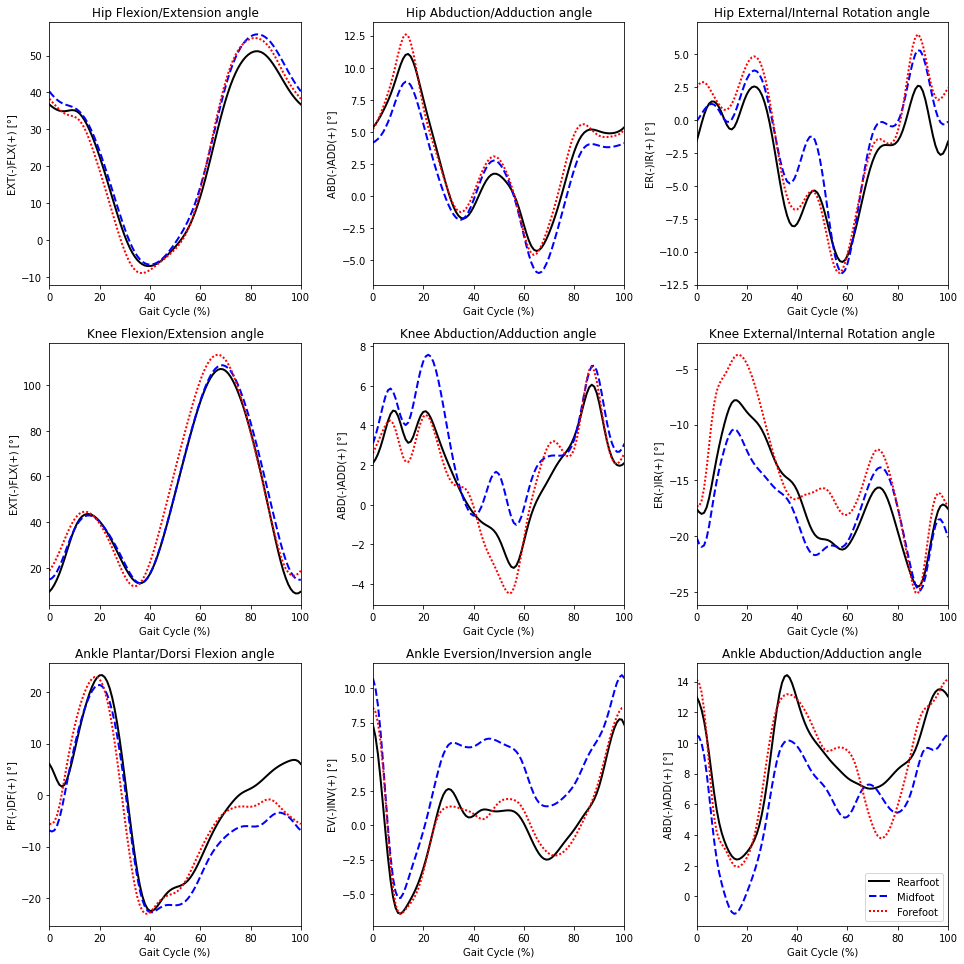

In [33]:
plot_biomech_factor(angles, 13.5, 13.5)

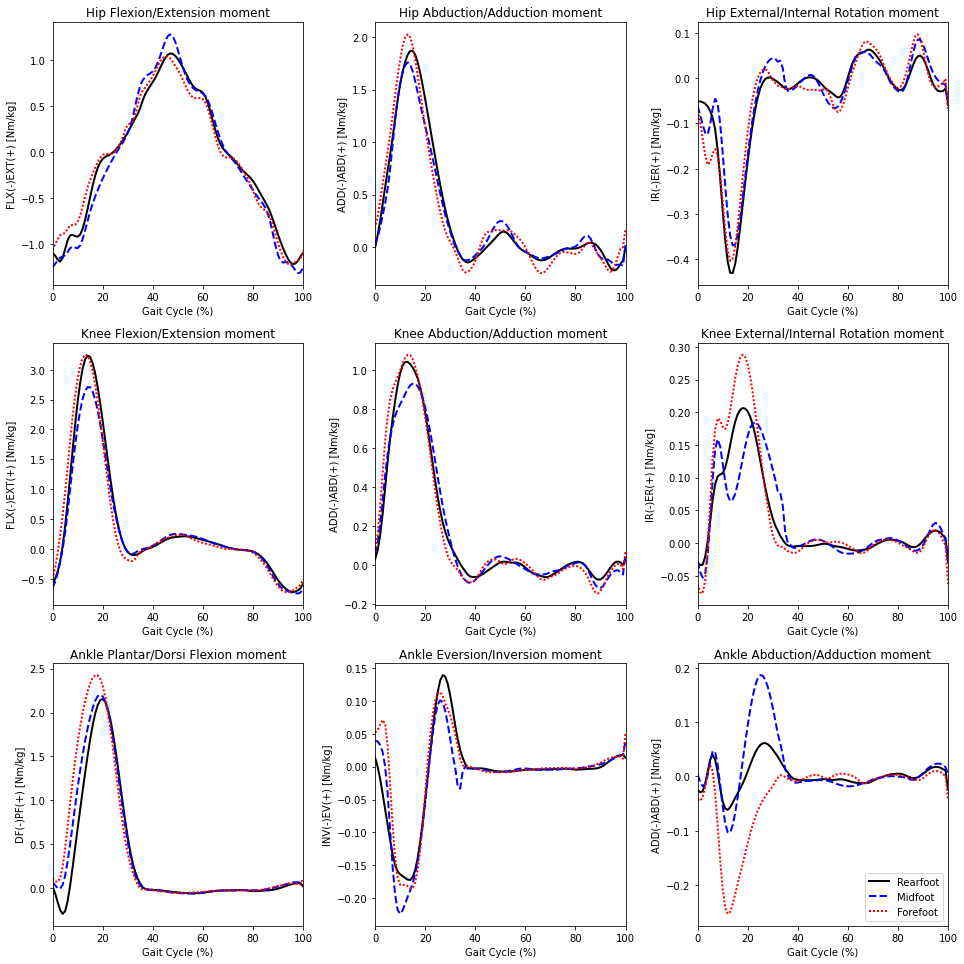

In [34]:
plot_biomech_factor(moments, 13.5, 13.5)

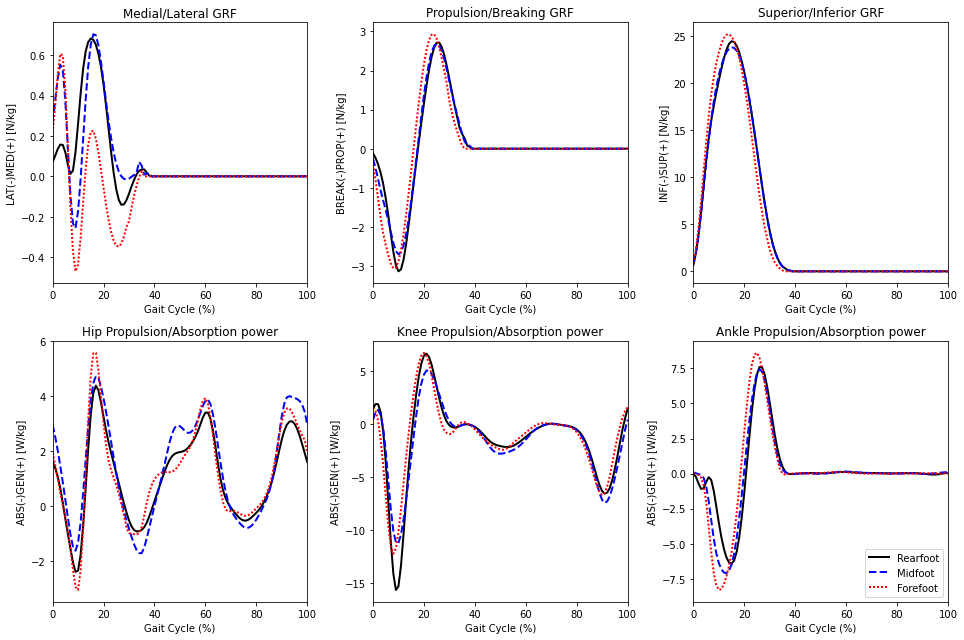

In [35]:
plot_biomech_factor(grf_and_power, 13.5, 9)

In [36]:
create_table(
    ['RankleAngZ35', 'RkneeAngZ35', 'RkneeMomZ35', 'RkneeMomZ35', 'RankleMomZ35', 'RankleMomZ35', 'RgrfY35',
     'RkneePow35', 'RkneePow35', 'RanklePow35', 'RanklePow35', 'RankleMomY35', 'RankleMomY35'],
    ['contact', 'contact', 'min', 'max', 'max', 'min', 'max', 'max', 'min', 'max', 'min', 'max', 'min'])

,RF_mean,RF_SD,MF_mean,MF_SD,FF_mean,FF_SD,F/H_value,p_value,FF-MF,FF-RF,MF-RF
Contact ankle PF/DF angle,6.07,5.07,-6.85,3.61,-5.58,2.84,19.99,0.000,0,1,1
Contact knee FLX/EXT angle,9.53,6.29,14.79,4.96,18.72,2.03,4.68,0.019,0,1,0
Max knee FLX moment,-0.73,0.07,-0.76,0.06,-0.74,0.02,0.27,0.767,0,0,0
Max knee EXT moment,3.27,0.46,2.75,0.44,3.27,0.40,2.44,0.108,0,0,0
Max ankle PF moment,2.19,0.23,2.22,0.20,2.46,0.10,2.65,0.090,0,0,0
Max ankle DF moment,-0.31,0.13,-0.07,0.02,-0.06,0.00,17.87,0.000,0,1,1
Max SUP GRF,24.66,1.34,24.10,1.27,25.30,1.80,1.25,0.535,0,0,0
Max knee GEN power,7.11,1.60,5.95,1.03,7.38,1.03,1.90,0.387,0,0,0
Max knee ABS power,-16.07,2.14,-11.57,2.08,-12.42,2.53,9.78,0.001,0,1,1
Max ankle GEN power,8.31,1.33,7.85,0.84,9.91,0.56,8.08,0.018,0,0,0


### Results

__Joint angles__<br>
Results showed significant differences between FF-RF and MF-RF ankle plantar/dorsiflexion contact angles, as well as significant differences between FF-RF knee flexion/extension contact angles. <br>
By definition, some difference should be present in the ankle and knee contact angles between foot strikes. However, as foot strike occurs on a continuous scale over the length of the foot, there will be a degree of variation within each group. As a result, RF and FF strikes which lie at either end of the scale may have been more likely show statistically significant differences.

__Joint moments__<br>
Out of those selected for statistical analysis, only the max ankle dorsiflexion moment showed statistical significance, with differences present between FF-RF and MF-RF. A sudden spike in rearfoot dorsiflexion moment is evident on the relevant moment graph and occurs simultaneously with a sudden change in ankle angle towards plantarflexion, as seen on the relevant angle graph. The lack of difference in knee extension and ankle plantarflexion moments is likely due to these variables peaking around midstance where any differences in joint angle between foot strikes has dissipated. 

__GRF__ <br>
Despite a characteristic spike in GRF often being present in rearfoot runners, no spike occured in this dataset and no significant difference in peak vertical GRF was found between foot strikes. On closer inspection of individual GRFs across all velocities, no participants elicited any notable spikes in vertical GRF, despite a previous study by Kulmala et al. (2013) showing significant spikes in vertical GRF at 4m/s. One explanation may be biomechanical differences between overground running seen in the paper by Kulmala et al. (2013) and treadmill running used in this study.

__Joint Power__ <br>
Max knee and ankle absorption powers were statistically significant, with differences between FF-RF and MF-RF at the knee joint, and between FF-RF at the ankle joint. It is logical that between propulsion and absorption powers, absorption power should show greater differences due its occurence between foot contact and midstance, where differences between foot strike are more pronounced.

### References


1. Bonacci, J., Saunders, P.U., Hicks, A., Rantalainen, T., Vicenzino, B.G.T. and Spratford, W., 2013. Running in a minimalist and lightweight shoe is not the same as running barefoot: a biomechanical study. _Br J Sports Med_, 47(6), pp.387-392.

2. Kerrigan, D.C., Franz, J.R., Keenan, G.S., Dicharry, J., Della Croce, U. and Wilder, R.P., 2009. The effect of running shoes on lower extremity joint torques. _Pm&r_, 1(12), pp.1058-1063.

3. Kulmala, J.P., Avela, J.A.N.N.E., Pasanen, K.A.T.I. and Parkkari, J.A.R.I., 2013. Forefoot strikers exhibit lower running-induced knee loading than rearfoot strikers. _Med Sci Sports Exerc_, 45(12), pp.2306-2313.

4. Rixe, J.A., Gallo, R.A. and Silvis, M.L., 2012. The barefoot debate: can minimalist shoes reduce running-related injuries?. _Current sports medicine reports_, 11(3), pp.160-165.
 
5. Squadrone, R. and Gallozzi, C., 2009. Biomechanical and physiological comparison of barefoot and two shod conditions in experienced barefoot runners. _J Sports Med Phys Fitness_, 49(1), pp.6-13.

6. Willy, R.W. and Davis, I.S., 2014. Kinematic and kinetic comparison of running in standard and minimalist shoes. _Medicine & Science in Sports & Exercise_, 46(2), pp.318-323.